![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/visual-nlp/2.2.Spark_OCR_training_Table_Recognition.ipynb)


# Spark-ocr demo for table recognition and free text extraction

The aim of this notebook is to show Spark-OCR abilities for
* Table recognition
* Free-text extraction

## Set up environment

#🎬 Installation

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
!pip install -q johnsnowlabs

# 🔑 Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to my.johnsnowlabs.com
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')

license_keys = files.upload()

# 🔑  Automatic Installation
Using my.johnsnowlabs.com SSO

In [ ]:
from johnsnowlabs import nlp, visual

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.install(refresh_install=True, visual=True)

#📌 Starting

In [ ]:
from johnsnowlabs import nlp, visual
import pandas as pd

# Automatically load license data and start a session with all jars user has access to
spark = nlp.start(visual=True)

👌 Launched cpu optimized session with with: 🚀Spark-NLP==4.4.1, 💊Spark-Healthcare==4.4.3, 🕶Spark-OCR==4.4.2, running on ⚡ PySpark==3.1.2


In [ ]:
import pkg_resources

from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

###  ⏳ Loading the sample

In [ ]:
from pyspark.ml import PipelineModel

!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/visual-nlp/data/cTDaR_t10096.jpg -P /content
imagePath = "/content/cTDaR_t10096.jpg"

df = spark.read.format("binaryFile").load(imagePath)
df.show()

--2023-06-18 10:46:47--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/visual-nlp/data/cTDaR_t10096.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 385071 (376K) [image/jpeg]
Saving to: ‘/content/cTDaR_t10096.jpg’

cTDaR_t10096.jpg    100%[===================>] 376.05K  --.-KB/s    in 0.04s   

2023-06-18 10:46:47 (8.91 MB/s) - ‘/content/cTDaR_t10096.jpg’ saved [385071/385071]

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/content/cTD...|2023-06-18 10:46:...|385071|[FF D8 FF E0 00 1...|
+--------------------+--------------------+------+------------------


### What if no table recognition?

One of the key features provided by Spark OCR is table recognition, which involves automatically detecting and extracting structured tabular data from documents.

Table recognition in Spark OCR is designed to identify tables within scanned images or PDF documents and extract the table structure along with the content of each cell. This is particularly useful when dealing with documents that contain structured information in tabular form, such as financial reports, invoices, or scientific data.

When table recognition is enabled in Spark OCR, the library applies advanced algorithms and techniques to analyze the document and identify areas that resemble tables. It leverages machine learning models and computer vision algorithms to detect table boundaries, locate rows and columns, and extract the text from each cell. This process allows Spark OCR to convert unstructured table data into structured data that can be further analyzed, processed, or exported to other formats.

However, if no table recognition is performed in Spark OCR, the library will not automatically detect and extract tables from the documents. In this case, the OCR process will focus on extracting text from the entire document, regardless of its structure. The extracted text will be provided as a result, but the specific tabular structure and organization of the content will not be preserved.

If table recognition is not needed or applicable to the documents being processed, Spark OCR can still be used as a powerful OCR solution for extracting text from various types of documents. It can handle tasks such as document digitization, text extraction from scanned images or PDFs, and text analysis at scale. The extracted text can then be utilized for various purposes, such as search indexing, data analysis, or information retrieval.

In [ ]:
from PIL import Image

In [ ]:
binary_to_image = visual.BinaryToImage()
binary_to_image.setOutputCol("image")
binary_to_image.setImageType(visual.ImageType.TYPE_3BYTE_BGR)

ocr = visual.ImageToText()
ocr.setInputCol("image")
ocr.setOutputCol("text")
ocr.setOcrParams(["preserve_interword_spaces=1", ])
ocr.setOutputSpaceCharacterWidth(10)

pipeline_ocr = PipelineModel(stages=[
    binary_to_image,
    ocr
])

result = pipeline_ocr.transform(df).cache()
print("\n".join([row.text for row in result.select("text").collect()]))

 

HISTORY, DEVELOPMENT AND CORPORATE STRUCTURE

 

(iii) Series B Financing

On April 28, 2018, the Company and its subsidiaries entered into the Series B Share
Purchase Agreement with the then Series B Preferred Shareholders, pursuant to which the then
Series B Preferred Shareholders agreed to subscribe for a maximum of 45,908,818 Series B
Preferred Shares in aggregate to be issued by our Company at a subscription price of
approximately US$5.66 per share and an aggregate consideration of approximately US$260
million. The Series B Preferred Shares were issued in full on May 8, 2018 as set forth in the
table below.

 

 

Number of
Series B            Purchase
Name of Shareholder                         Preferred Shares            Amount
(US$)
WuXi Healthcare Ventures                              882,861        4,999,994.99
6 Dimensions Capital, L.P.                             3,354,875       18,999,999.08
6 Dimensions Affiliates Fund, L.P.                       176,572         999,99


### ⏩ Table data extraction

In [ ]:
binary_to_image = visual.BinaryToImage()
binary_to_image.setOutputCol("image")
binary_to_image.setImageType(visual.ImageType.TYPE_3BYTE_BGR)

# Detect tables on the page using pretrained model
# It can be finetuned for have more accurate results for more specific documents
table_detector = visual.ImageTableDetector.pretrained("general_model_table_detection_v2", "en", "clinical/ocr")
table_detector.setInputCol("image")
table_detector.setOutputCol("region")

# Draw detected region's with table to the page
draw_regions = visual.ImageDrawRegions()
draw_regions.setInputCol("image")
draw_regions.setInputRegionsCol("region")
draw_regions.setOutputCol("image_with_regions")
draw_regions.setRectColor(visual.Color.red)

# Extract table regions to separate images
splitter = visual.ImageSplitRegions()
splitter.setInputCol("image")
splitter.setInputRegionsCol("region")
splitter.setOutputCol("table_image")
splitter.setDropCols("image")

# Detect cells on the table image
cell_detector = visual.ImageTableCellDetector()
cell_detector.setInputCol("table_image")
cell_detector.setOutputCol("cells")
cell_detector.setAlgoType("morphops")
cell_detector.setDrawDetectedLines(True)

# Extract text from the detected cells
table_recognition = visual.ImageCellsToTextTable()
table_recognition.setInputCol("table_image")
table_recognition.setCellsCol('cells')
table_recognition.setMargin(3)
table_recognition.setStrip(True)
table_recognition.setOutputCol('table')

# Erase detected table regions
fill_regions = visual.ImageDrawRegions()
fill_regions.setInputCol("image")
fill_regions.setInputRegionsCol("region")
fill_regions.setOutputCol("image_1")
fill_regions.setRectColor(visual.Color.white)
fill_regions.setFilledRect(True)

# OCR
ocr = visual.ImageToText()
ocr.setInputCol("image_1")
ocr.setOutputCol("text")
ocr.setOcrParams(["preserve_interword_spaces=1", ])
ocr.setKeepLayout(True)
ocr.setOutputSpaceCharacterWidth(8)

pipeline_table = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    draw_regions,
    fill_regions,
    splitter,
    cell_detector,
    table_recognition,
    ocr
])

tables_results = pipeline_table.transform(df).cache()

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB


In [ ]:
tables_results.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+-------+--------------------+--------------------+--------------------+--------------------+-----------------+---------+--------------------+--------------------+
|         table_image|              region|               image|    modificationTime|             image_1|                path|length|pagenum|  image_with_regions|               cells|        output_image|               table|       confidence|exception|                text|           positions|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+-------+--------------------+--------------------+--------------------+--------------------+-----------------+---------+--------------------+--------------------+
|{file:/content/cT...|{0, 0, 214.0, 437...|{file:/content/cT...|2023-06-18 10:46:...|{file:/content/cT...|fil


    Image #0:
    Origin: file:/content/cTDaR_t10096.jpg
    Resolution: 0 dpi
    Width: 1190 px
    Height: 1588 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


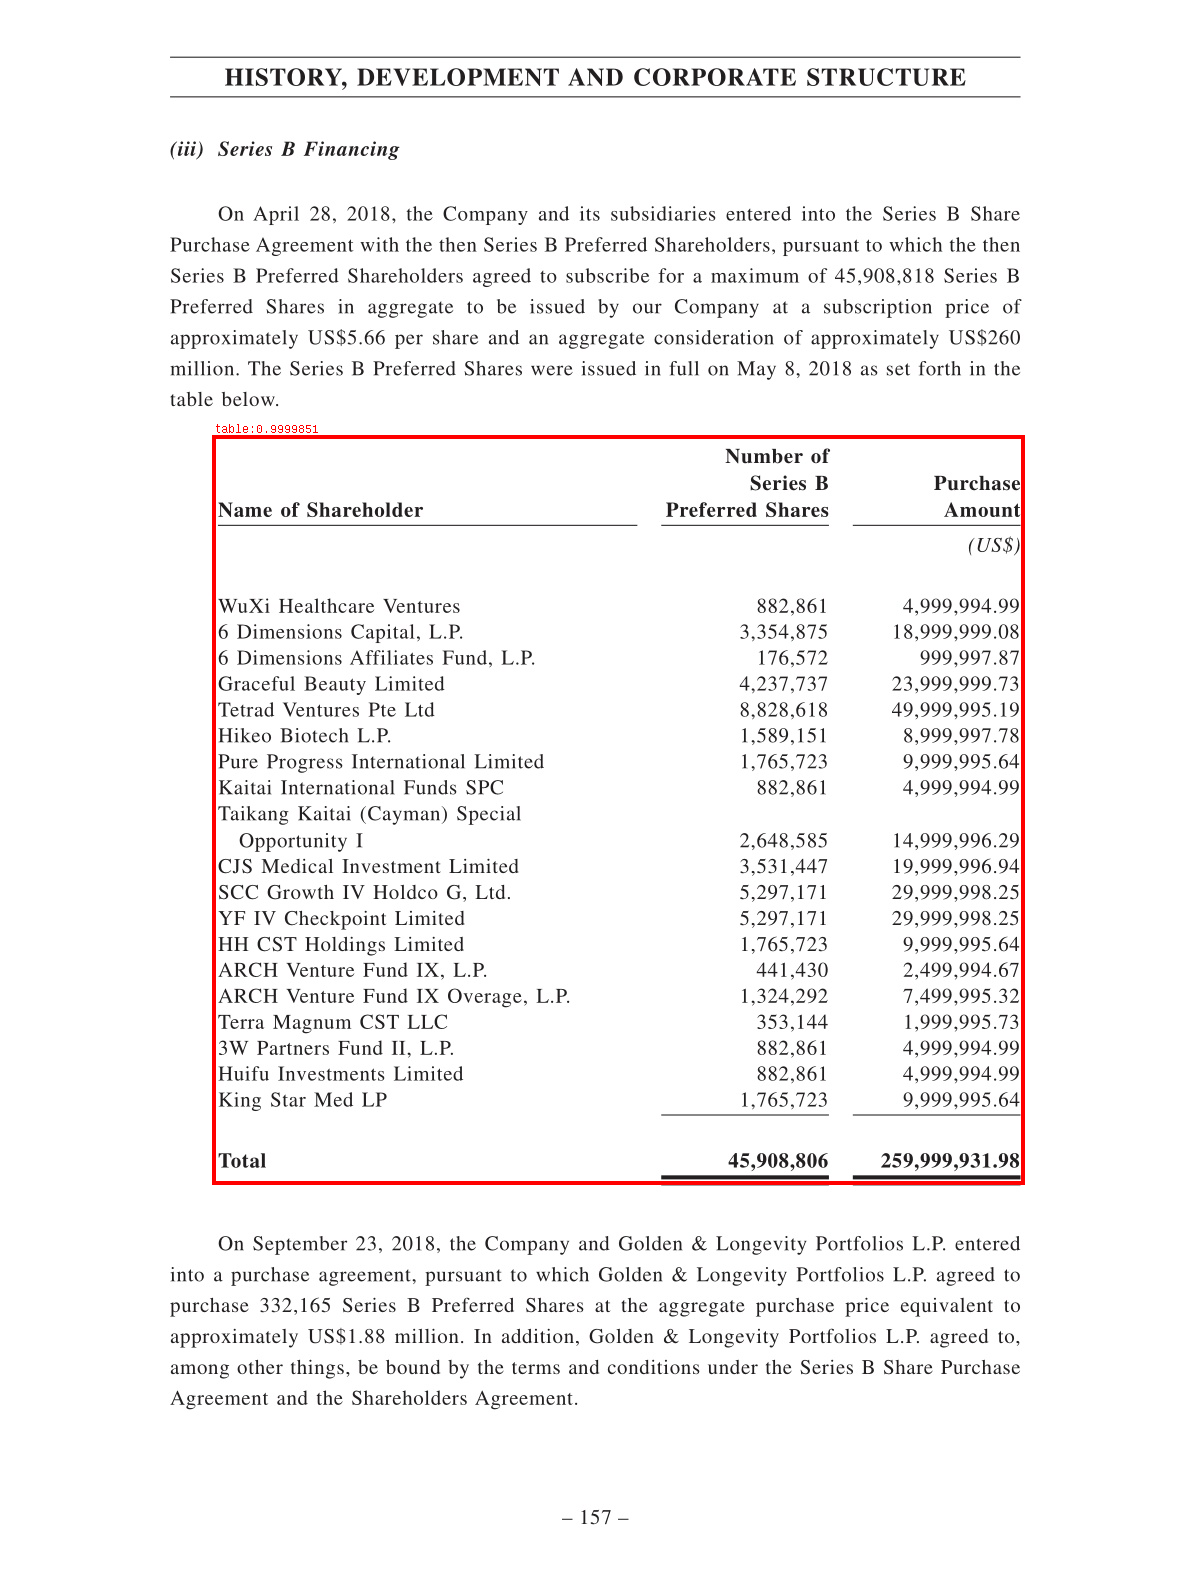

CPU times: user 275 ms, sys: 24.3 ms, total: 300 ms
Wall time: 610 ms


In [ ]:
%%time
visual.display_images(tables_results, "image_with_regions")

## ⏩ Tables

In [ ]:
visual.display_tables(tables_results)

Filename: cTDaR_t10096.jpg
Page:     0
Table:    0
3


,col0,col1,col2
0,,Number of,
1,,Series B,Purchase
2,Name of Shareholder,Preferred Shares,Amount
3,,,(US$)
4,WuXi Healthcare Ventures,882.861,4.999 _994.99
5,"6 Dimensions Capital, L.P.",9 A354: 875,18.999.999.08
6,"6 Dimensions Affiliates Fund, L.P.",176.572,999 997.87
7,Graceful Beauty Limited,4.937.737,"23,.999.999,73"
8,Tetrad Ventures Pte Ltd,8.828.618,49.999 .995.19
9,Hikeo Biotech L.P.,"1,589,151","8,999.997.78"


## ⏩ Free text

In [ ]:
tables_results.select("text").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## ⏩ Processing of PDF


In [ ]:
!gdown 1AhAKlyxX_PEWI9bI0M0KH0wgzrKOpLTt

Downloading...
From: https://drive.google.com/uc?id=1AhAKlyxX_PEWI9bI0M0KH0wgzrKOpLTt
To: /content/budget.pdf
100% 339k/339k [00:00<00:00, 159MB/s]


In [ ]:
pdfPath = "/content/budget.pdf"

pdf_df = spark.read.format("binaryFile").load(pdfPath)

pdf_to_image = visual.PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setImageType(visual.ImageType.TYPE_3BYTE_BGR) \
    .setKeepInput(True)\
    .setResolution(100)

pipeline_table_pdf = PipelineModel(stages=[
    pdf_to_image,
    table_detector,
    draw_regions,
    fill_regions,
    splitter,
    cell_detector,
    table_recognition,
    ocr
])

tables_results_pdf = pipeline_table_pdf.transform(pdf_df).cache()


    Image #0:
    Origin: file:/content/budget.pdf
    Resolution: 0 dpi
    Width: 1169 px
    Height: 826 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


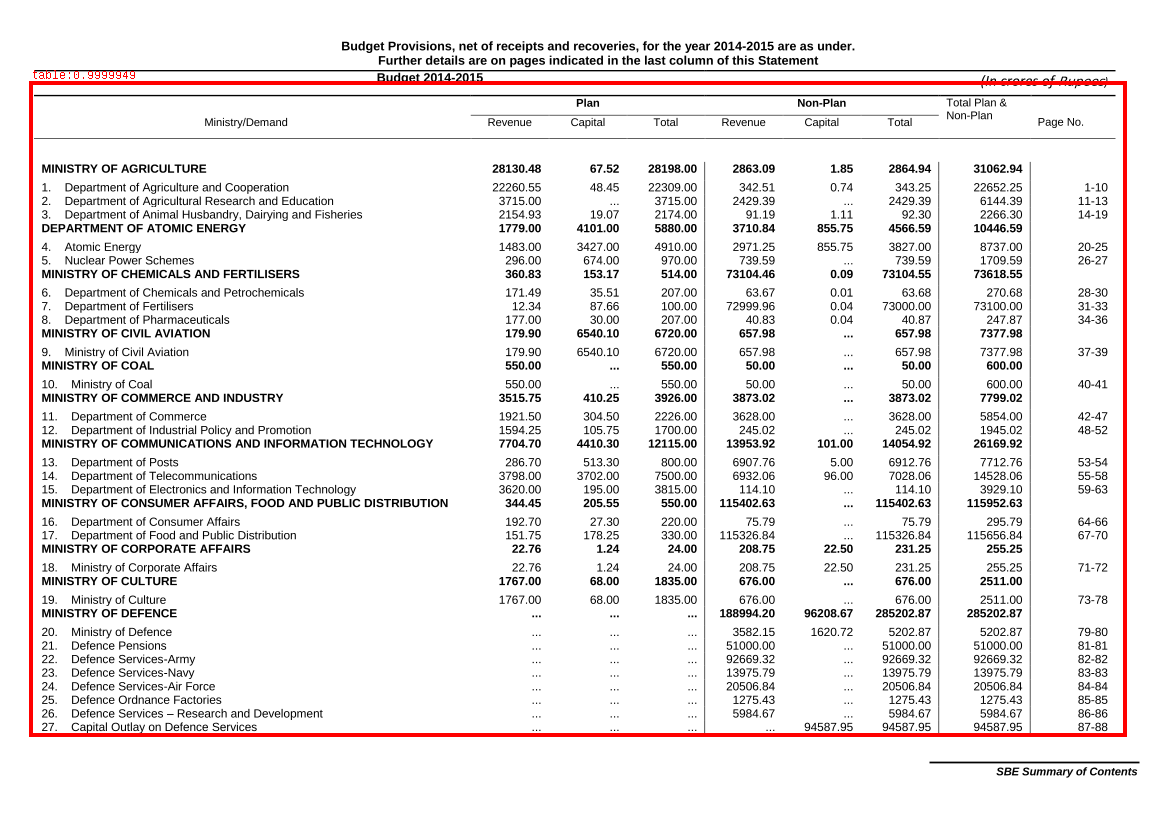

CPU times: user 256 ms, sys: 28.3 ms, total: 284 ms
Wall time: 30.7 s


In [ ]:
%%time
visual.display_images(tables_results_pdf, "image_with_regions")

Table extracted from pdf

In [ ]:
visual.display_tables(tables_results_pdf)

Filename: budget.pdf
Page:     0
Table:    0
-1


""
